# Demand Forecasting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore") # Ignore harmless warnings

In [32]:
# --- Step 0: Load and Initial Data Preparation ---
df=pd.read_excel("edaoutput.xlsx",index_col=0)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3271 entries, 0 to 3270
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   ActivitySiteID                           3271 non-null   object        
 1   BookingEndDateTime (Month / Day / Year)  3271 non-null   datetime64[ns]
 2   BookingStartTime                         3271 non-null   object        
 3   MaxBookees                               3271 non-null   float64       
 4   Number Booked                            3271 non-null   int64         
 5   Price (INR)                              3271 non-null   int64         
 6   ActivityDescription_clean                3271 non-null   object        
 7   Price_log                                3271 non-null   float64       
 8   NumberBooked_log                         3271 non-null   float64       
 9   Price_Tier                               3271 

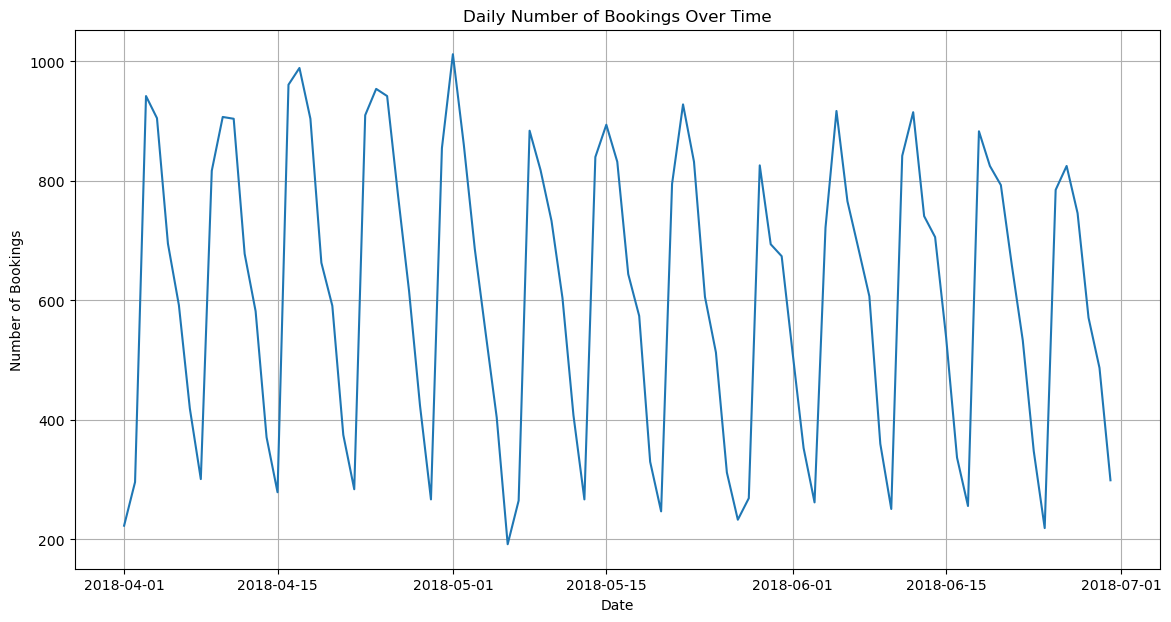

In [15]:
# --- Step 1: Prepare Time Series Data ---

# 1.1 Ensure the date column is datetime and set as index
# Rename the column for easier access
df.rename(columns={'BookingEndDateTime (Month / Day / Year)': 'BookingDate'}, inplace=True)
df['BookingDate'] = pd.to_datetime(df['BookingDate'])
df.set_index('BookingDate', inplace=True)

# 1.2 Aggregate 'Number Booked' by time frequency
# Time series models require data at a regular frequency.
# Let's aggregate daily bookings for this example. You might choose 'W' for weekly or 'M' for monthly.
# Summing bookings for each day.
daily_bookings = df['Number Booked'].resample('D').sum().fillna(0) # Fill NaNs if some days have no bookings

# Optional: Visualize the time series
plt.figure(figsize=(14, 7))
plt.plot(daily_bookings)
plt.title('Daily Number of Bookings Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.grid(True)
plt.show()

In [16]:
# 1.3 Create the time series variable for modeling
ts_data = daily_bookings.copy()
print(f"Time series data prepared with {len(ts_data)} observations.")

Time series data prepared with 91 observations.


In [17]:
# --- Step 2: Select and Train Forecasting Model (ARIMA Example) ---

# ARIMA (AutoRegressive Integrated Moving Average) is a common choice.
# It takes three parameters (p, d, q):
# p: The number of lag observations included in the model (AR part).
# d: The number of times the raw observations are differenced (I part for stationarity).
# q: The size of the moving average window (MA part).
# Choosing p, d, q often involves analyzing ACF/PACF plots or using auto_arima.
# For this example, we'll use a placeholder (1, 1, 1). You'll need to optimize these.

# 2.1 Split data into training and testing sets (chronologically)

train_size = int(len(ts_data) * 0.8) # 80% for training
train_ts, test_ts = ts_data[0:train_size], ts_data[train_size:]

print(f"\nTraining set size: {len(train_ts)} observations (up to {train_ts.index[-1].date()})")
print(f"Test set size: {len(test_ts)} observations (from {test_ts.index[0].date()})")


Training set size: 72 observations (up to 2018-06-11)
Test set size: 19 observations (from 2018-06-12)


In [23]:
# 2.2 Train the ARIMA model
# model_order = (p, d, q)
model_order = (1, 1, 1) # Placeholder: You should determine optimal p, d, q
print(f"Training ARIMA model with order {model_order}...")
arima_model = ARIMA(train_ts, order=model_order)
arima_fit = arima_model.fit()

print("\nARIMA Model Training Summary:")
print(arima_fit.summary())

Training ARIMA model with order (1, 1, 1)...

ARIMA Model Training Summary:
                               SARIMAX Results                                
Dep. Variable:          Number Booked   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -487.470
Date:                Fri, 18 Jul 2025   AIC                            980.940
Time:                        16:09:26   BIC                            987.729
Sample:                    04-01-2018   HQIC                           983.640
                         - 06-11-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4601      0.141      3.274      0.001       0.185       0.736
ma.L1         -0.9995      5.572     -0.179      0.858 

In [25]:
# --- Step 3: Validate Forecasts ---

# 3.1 Generate forecasts
# The start and end points for forecasting should align with your test set.
start_forecast_idx = len(train_ts)
end_forecast_idx = len(ts_data) - 1 # Last index of the full time series
forecast_results = arima_fit.predict(start=start_forecast_idx, end=end_forecast_idx, typ='levels')

# Assign index from test_ts to forecast_results for easier plotting
forecast_results.index = test_ts.index

# Ensure forecasts don't go below zero if bookings cannot be negative
forecast_results[forecast_results < 0] = 0

In [27]:
# 3.2 Evaluate model accuracy
mae = mean_absolute_error(test_ts, forecast_results)
mse = mean_squared_error(test_ts, forecast_results)
rmse = np.sqrt(mse)

print(f"\n--- Forecast Validation Metrics ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


--- Forecast Validation Metrics ---
Mean Absolute Error (MAE): 184.9946
Mean Squared Error (MSE): 45168.8958
Root Mean Squared Error (RMSE): 212.5298


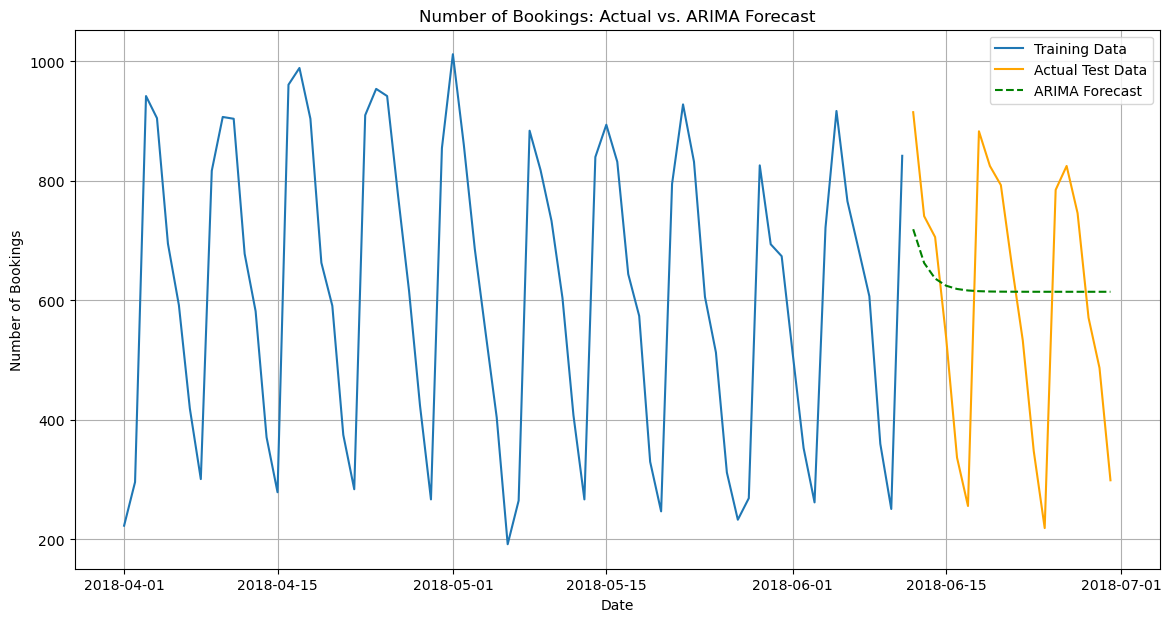


Time series forecasting and validation complete. Review the plot and metrics.


In [29]:
# 3.3 Generate and plot forecasts
plt.figure(figsize=(14, 7))
plt.plot(train_ts.index, train_ts, label='Training Data')
plt.plot(test_ts.index, test_ts, label='Actual Test Data', color='orange')
plt.plot(forecast_results.index, forecast_results, label='ARIMA Forecast', color='green', linestyle='--')
plt.title('Number of Bookings: Actual vs. ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.legend()
plt.grid(True)
plt.show()

print("\nTime series forecasting and validation complete. Review the plot and metrics.")

In [ ]:
pip install prophet

Prophet data prepared with 300 observations.
Prophet DataFrame head:
          ds          y
0 2023-01-01  81.000000
1 2023-01-02  92.336795
2 2023-01-03   9.667612
3 2023-01-04  84.986497
4 2023-01-05  93.287552

Training set size: 240 observations (up to 2023-08-28)
Test set size: 60 observations (from 2023-08-29)

Training Prophet model...


16:10:40 - cmdstanpy - INFO - Chain [1] start processing
16:10:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully.

--- Prophet Forecast Validation Metrics ---
Mean Absolute Error (MAE): 30.8809
Mean Squared Error (MSE): 1472.2973
Root Mean Squared Error (RMSE): 38.3705


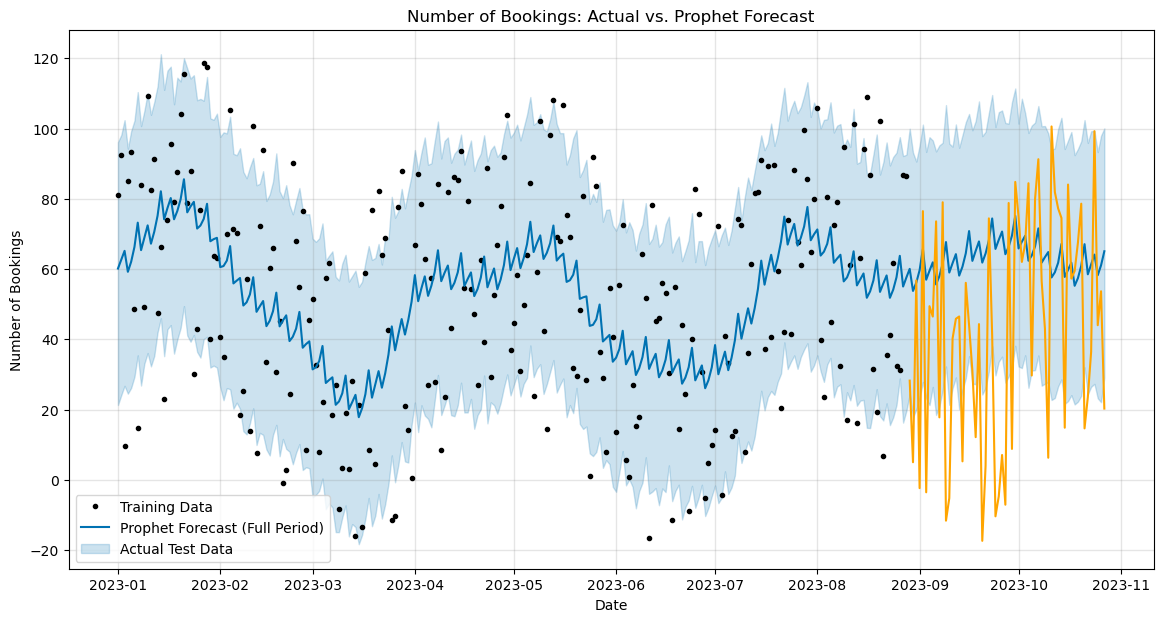

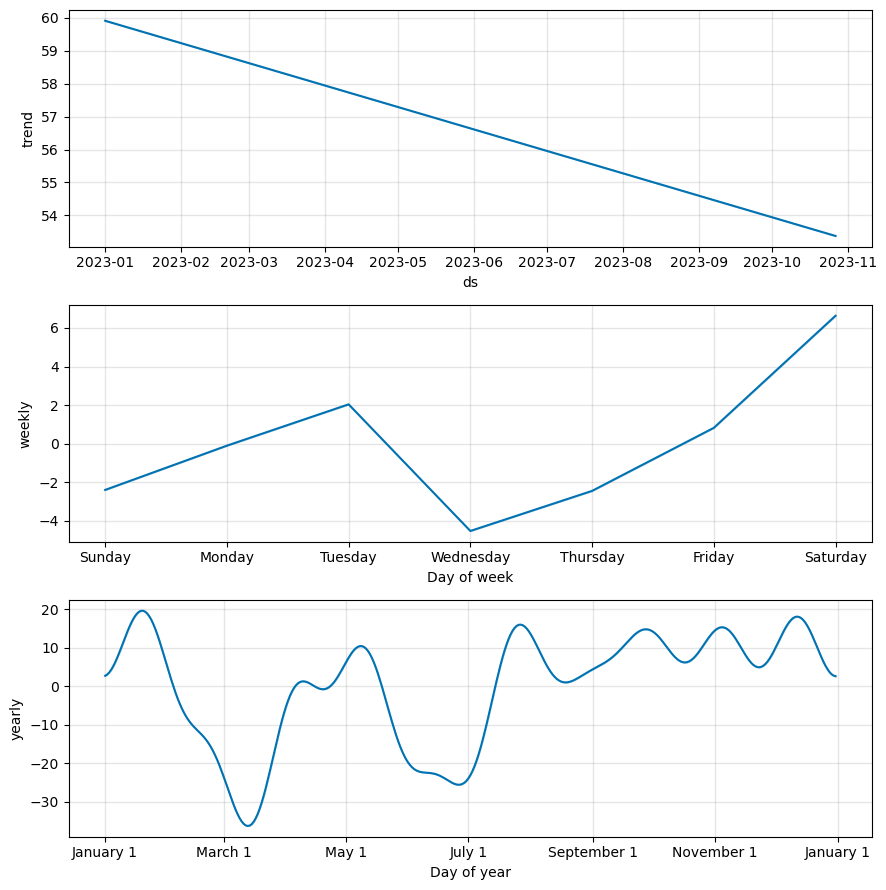


Prophet forecasting and validation complete. Review the plots and metrics.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet # Import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore") # Ignore harmless warnings

# --- Step 0: Load and Initial Data Preparation (from previous steps) ---
# Ensure your DataFrame 'df' is loaded and has the 'Number Booked' and
# 'BookingEndDateTime (Month / Day / Year)' columns.

# This dummy DataFrame mimics the necessary columns for demonstration.
# REPLACE THIS WITH YOUR ACTUAL DATAFRAME LOADING AND PROCESSING!
num_observations = 300 # Prophet works well with more data, adjust as needed
data = {
    'BookingEndDateTime (Month / Day / Year)': pd.to_datetime(pd.date_range(start='2023-01-01', periods=num_observations, freq='D')),
    'Number Booked': np.random.randint(1, 100, num_observations) + np.sin(np.linspace(0, 20, num_observations)) * 20, # Add some seasonality
}
df = pd.DataFrame(data)

# Rename the date column for easier access and consistency
df.rename(columns={'BookingEndDateTime (Month / Day / Year)': 'BookingDate'}, inplace=True)
df['BookingDate'] = pd.to_datetime(df['BookingDate'])

# Aggregate 'Number Booked' by time frequency (daily for Prophet)
# Prophet works best with regular daily, weekly, or monthly data.
daily_bookings = df.set_index('BookingDate')['Number Booked'].resample('D').sum().fillna(0)

# --- Step 1: Prepare Data for Prophet ---

# Prophet requires a DataFrame with specific column names:
# 'ds' (datetime) for the time series
# 'y' (numerical) for the value to be forecasted
prophet_df = daily_bookings.reset_index()
prophet_df.columns = ['ds', 'y']

print(f"Prophet data prepared with {len(prophet_df)} observations.")
print("Prophet DataFrame head:")
print(prophet_df.head())

# --- Step 2: Select and Train Forecasting Model (Prophet) ---

# 2.1 Split data into training and testing sets (chronologically)
# Prophet handles missing data, but it's good practice to define clear train/test.
train_size = int(len(prophet_df) * 0.8) # 80% for training
train_prophet_df = prophet_df.iloc[:train_size]
test_prophet_df = prophet_df.iloc[train_size:]

print(f"\nTraining set size: {len(train_prophet_df)} observations (up to {train_prophet_df['ds'].iloc[-1].date()})")
print(f"Test set size: {len(test_prophet_df)} observations (from {test_prophet_df['ds'].iloc[0].date()})")

# 2.2 Instantiate and train the Prophet model
# You can add parameters for seasonality (e.g., daily_seasonality=True, weekly_seasonality=True)
# if you expect those patterns and Prophet doesn't detect them automatically or needs explicit control.
# monthly_seasonality can be added as add_seasonality.
print("\nTraining Prophet model...")
m = Prophet(
    daily_seasonality=False, # Set to True if your data shows strong daily patterns
    weekly_seasonality=True, # Often useful for booking data
    yearly_seasonality=True # Often useful if you have multiple years of data
)

# You can add country holidays if applicable (e.g., US holidays)
# from prophet.make_holidays import get_holiday_names, get_country_holidays
# holidays = get_country_holidays(country_name='US') # Replace with 'IN' for India if available
# m.add_country_holidays(country_name='US')

m.fit(train_prophet_df)
print("Prophet model trained successfully.")

# --- Step 3: Validate Forecasts ---

# 3.1 Make future dataframe for predictions
# period: Number of periods to forecast into the future
# freq: Frequency of future periods (e.g., 'D' for daily, 'W' for weekly)
future = m.make_future_dataframe(periods=len(test_prophet_df), freq='D')
forecast = m.predict(future)

# 3.2 Extract relevant forecasts for evaluation
# Align forecast with the test set dates
forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test_prophet_df['ds']].reset_index()

# Ensure forecasts don't go below zero if bookings cannot be negative
forecast_test['yhat'][forecast_test['yhat'] < 0] = 0

# 3.3 Evaluate model accuracy on the test set
mae = mean_absolute_error(test_prophet_df['y'], forecast_test['yhat'])
mse = mean_squared_error(test_prophet_df['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)

print(f"\n--- Prophet Forecast Validation Metrics ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 3.4 Generate and plot forecasts
plt.figure(figsize=(14, 7))
m.plot(forecast, ax=plt.gca()) # Plots actuals and forecasts
plt.plot(test_prophet_df['ds'], test_prophet_df['y'], label='Actual Test Data', color='orange') # Re-add actual test data for clarity
plt.title('Number of Bookings: Actual vs. Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.legend(['Training Data', 'Prophet Forecast (Full Period)', 'Actual Test Data'])
plt.grid(True)
plt.show()

# Optional: Plot components of the forecast (trend, seasonality)
fig2 = m.plot_components(forecast)
plt.show()

print("\nProphet forecasting and validation complete. Review the plots and metrics.")